In [128]:
import os
from dotenv import load_dotenv
load_dotenv()

True

In [129]:
model="meta-llama/llama-4-scout-17b-16e-instruct"
from langchain_groq import ChatGroq
llm=ChatGroq(model_name=model)
llm.invoke("What is the capital of France?")

AIMessage(content='The capital of France is Paris.', additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 8, 'prompt_tokens': 17, 'total_tokens': 25, 'completion_time': 0.019650929, 'prompt_time': 0.003000436, 'queue_time': 0.09775945700000001, 'total_time': 0.022651365}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'stop', 'logprobs': None}, id='run--23e665f5-726f-473b-b252-85d99193ce2f-0', usage_metadata={'input_tokens': 17, 'output_tokens': 8, 'total_tokens': 25})

In [130]:
print(llm.invoke("What is the capital of France?").content)

The capital of France is Paris.


In [131]:
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage,AIMessage
from langgraph.graph import StateGraph,END,START,MessagesState
from langgraph.prebuilt import ToolNode

## Desiging a simple workflow with tool Calling


In [132]:
## Custom tool


@tool
def search(query: str) -> str:
    """this is my custom tool for searching a weather"""
    if "delhi" in query.lower():
        return "the temp is 45 degree and sunny"
    return "the temp is 25 degree and cloudy"

In [133]:
search.invoke("what is the weather in delhi?")

'the temp is 45 degree and sunny'

In [134]:
search.invoke("what is the weather in New Jersey?")

'the temp is 25 degree and cloudy'

In [135]:
search

StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000016F07FCE520>)

In [136]:
llm.invoke("What is the weather in France?")

AIMessage(content="The weather in France! As a large country with a diverse geography, France experiences a variety of climates and weather conditions. Here's a general overview:\n\n**Seasonal Weather Patterns:**\n\n1. **Spring (March to May)**: Mild temperatures, with averages ranging from 10°C (50°F) in the north to 15°C (59°F) in the south. Showers are common, but sunny days are also frequent.\n2. **Summer (June to August)**: Warm and sunny, with temperatures often reaching 25°C (77°F) in the south and 22°C (72°F) in the north. Coastal areas tend to be cooler than inland regions.\n3. **Autumn (September to November)**: Cooler temperatures, with averages ranging from 10°C (50°F) in the north to 15°C (59°F) in the south. Rainfall increases, especially in the northwest.\n4. **Winter (December to February)**: Cool to cold temperatures, with averages ranging from 2°C (36°F) in the north to 6°C (43°F) in the south. Snowfall is common in the Alps and the Pyrenees.\n\n**Regional Weather Pat

In [137]:
llm.invoke("What is the weather in delhi?")

AIMessage(content="I'm not able to provide real-time information such as current weather conditions. However, I can suggest some ways for you to find out the current weather in Delhi:\n\n1. Check online weather websites: You can visit websites like AccuWeather, Weather.com, or Times of India Weather to get the current weather conditions in Delhi.\n2. Use a weather app: Download a weather app like Dark Sky, Weather Underground, or The Weather Channel app on your smartphone to get the current weather conditions in Delhi.\n3. Check local news: You can check local news websites or TV channels for the current weather conditions in Delhi.\n\nAs of my knowledge cutoff in 2023, Delhi has a humid subtropical climate with extremely hot summers and mild winters. The best time to visit Delhi is from October to February, when the weather is pleasant and comfortable.", additional_kwargs={}, response_metadata={'token_usage': {'completion_tokens': 168, 'prompt_tokens': 18, 'total_tokens': 186, 'comple


 ## Binding a tool to the LLM
Special Note: use some good for agentic workflow since opensource model might not give you the correct output

In [138]:
tools=[search]

In [139]:
llm_with_tool=llm.bind_tools(tools)

In [140]:
response =llm_with_tool.invoke("What is the weather in delhi?")
response

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'hftgt1310', 'function': {'arguments': '{"query":"delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 678, 'total_tokens': 702, 'completion_time': 0.055426267, 'prompt_time': 0.025155368, 'queue_time': 0.05215191300000001, 'total_time': 0.080581635}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_37da608fc1', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--46e70251-cd5b-4a73-ae45-66087bfc2835-0', tool_calls=[{'name': 'search', 'args': {'query': 'delhi weather'}, 'id': 'hftgt1310', 'type': 'tool_call'}], usage_metadata={'input_tokens': 678, 'output_tokens': 24, 'total_tokens': 702})

In [141]:
response.content

''

In [142]:
response.tool_calls

[{'name': 'search',
  'args': {'query': 'delhi weather'},
  'id': 'hftgt1310',
  'type': 'tool_call'}]

In [143]:
def call_model(state:MessagesState):
    question=state["messages"]
    response=llm_with_tool.invoke(question)
    return {"messages":[response]}


In [144]:
input={"messages":["what is a weather in delhi?"]}

In [145]:
response=call_model(input)

In [146]:
response['messages'][-1].content

''

In [147]:
response["messages"][-1].tool_calls

[{'name': 'search',
  'args': {'query': 'weather in delhi'},
  'id': 'hwrt619e1',
  'type': 'tool_call'}]

##  here my router function
now whatever will come from call_model router funtion will redirect this to the appropriate tool

In [148]:
def router_function(state:MessagesState):
    message=state["messages"]
    last_message=message[-1]
    if last_message.tool_calls:
        return "tools"
    return END


In [149]:
tools

[StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000016F07FCE520>)]

In [150]:
tool_node = ToolNode(tools)

In [151]:
tool_node

tools(tags=None, recurse=True, explode_args=False, func_accepts_config=True, func_accepts={'store': ('__pregel_store', None)}, tools_by_name={'search': StructuredTool(name='search', description='this is my custom tool for searching a weather', args_schema=<class 'langchain_core.utils.pydantic.search'>, func=<function search at 0x0000016F07FCE520>)}, tool_to_state_args={'search': {}}, tool_to_store_arg={'search': None}, handle_tool_errors=True, messages_key='messages')

In [152]:
workflow=StateGraph(MessagesState)

In [153]:
workflow.add_node("llmwithtool",call_model)

In [154]:
workflow.add_node("mytools",tool_node)
workflow.add_edge(START, "llmwithtool")
workflow.add_conditional_edges(
    "llmwithtool",
    router_function,
    {
        "tools": "mytools",
        END: END
    }
)

In [155]:
app=workflow.compile()

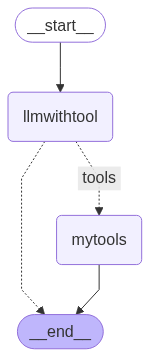

In [156]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

In [157]:
response=app.invoke({"messages":["What is the weather in delhi?"]})

In [158]:
response['messages'][-1].content

'the temp is 45 degree and sunny'

In [159]:

app.invoke({"messages":["what is a weather in delhi?"]})

{'messages': [HumanMessage(content='what is a weather in delhi?', additional_kwargs={}, response_metadata={}, id='a6554e9f-1235-46e1-8a4e-c69b275f978c'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '0t4t1qr2a', 'function': {'arguments': '{"query":"weather in delhi"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 25, 'prompt_tokens': 678, 'total_tokens': 703, 'completion_time': 0.057186811, 'prompt_time': 0.023817139, 'queue_time': 0.050961961, 'total_time': 0.08100395}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--545c3914-a314-42ec-818f-0acd16e1bed4-0', tool_calls=[{'name': 'search', 'args': {'query': 'weather in delhi'}, 'id': '0t4t1qr2a', 'type': 'tool_call'}], usage_metadata={'input_tokens': 678, 'output_tokens': 25, 'total_tokens': 703}),
  ToolMessage(content='the temp is 45 degree and sunny', nam

use good resoning based model

In [160]:
workflow.add_edge("mytools", "llmwithtool")

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


In [161]:
app2=workflow.compile()

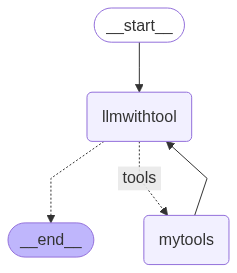

In [162]:
from IPython.display import Image, display
display(Image(app2.get_graph().draw_mermaid_png()))

In [163]:
for output in app2.stream({"messages":["what is the weather in delhi?"]}):
    for key,value in output.items():
        print(f"here is output from {key}")
        print("_______")
        print(value)
        print("\n")


here is output from llmwithtool
_______
{'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'ne7pe3nw5', 'function': {'arguments': '{"query":"delhi weather"}', 'name': 'search'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 678, 'total_tokens': 702, 'completion_time': 0.055831827, 'prompt_time': 0.022076338, 'queue_time': 0.051315191999999996, 'total_time': 0.077908165}, 'model_name': 'meta-llama/llama-4-scout-17b-16e-instruct', 'system_fingerprint': 'fp_79da0e0073', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--9f06d6af-7ac8-428a-9c99-7f513019d367-0', tool_calls=[{'name': 'search', 'args': {'query': 'delhi weather'}, 'id': 'ne7pe3nw5', 'type': 'tool_call'}], usage_metadata={'input_tokens': 678, 'output_tokens': 24, 'total_tokens': 702})]}


here is output from mytools
_______
{'messages': [ToolMessage(content='the temp is 45 degree and sunny', name='search', id='5f2d8d61-facf-41dd-96ac-07d419d


"what is a weather in delhi can you tell me some good hotel for staying in north delhi"

In [ ]:
## using memory
# This is a simple example of using memory in langgraph
# We will use a memory node to store the last question asked and the answer given by the model.
# This will allow us to keep track of the conversation and use it in the next question.

In [164]:
from langgraph.checkpoint.memory import MemorySaver
memory= MemorySaver()

In [165]:
workflow2=StateGraph(MessagesState)
workflow2.add_node("llmwithtool",call_model)
workflow2.add_node("mytools",tool_node)
workflow2.add_edge(START, "llmwithtool")
workflow2.add_conditional_edges(
    "llmwithtool",
    router_function,
    {
        "tools": "mytools",
        END: END
    }
)
workflow2.add_edge("mytools", "llmwithtool")

In [166]:
app3=workflow2.compile(checkpointer=memory)

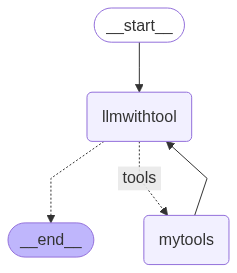

In [167]:
from IPython.display import Image, display
display(Image(app3.get_graph().draw_mermaid_png()))

In [168]:
config={"configurable":{"thread_id":"1"}}

In [169]:
events=app3.stream({"messages":["what is the weather in delhi?"]},config=config,stream_mode="values")

In [170]:
for event in events:
    event["messages"][-1].pretty_print()
    print("\n")


================================ Human Message =================================

what is the weather in delhi?


================================== Ai Message ==================================
Tool Calls:
  search (6rzgbc6e4)
 Call ID: 6rzgbc6e4
  Args:
    query: delhi weather


================================= Tool Message =================================
Name: search

the temp is 45 degree and sunny


================================== Ai Message ==================================

The current weather in Delhi is sunny with a temperature of 45 degrees.




In [171]:
events=app3.stream(
    {"messages":["what is a weather in indore?"]},config=config,stream_mode="values")

In [172]:
for event in events:
    event["messages"][-1].pretty_print()
    print("\n")

================================ Human Message =================================

what is a weather in indore?


================================== Ai Message ==================================
Tool Calls:
  search (nxw2qzg7h)
 Call ID: nxw2qzg7h
  Args:
    query: indore weather


================================= Tool Message =================================
Name: search

the temp is 25 degree and cloudy


================================== Ai Message ==================================

The current weather in Indore is cloudy with a temperature of 25 degrees.




In [173]:
config

{'configurable': {'thread_id': '1'}}

In [176]:
memory.get(config) 

{'v': 4,
 'ts': '2025-07-16T05:51:51.781025+00:00',
 'id': '1f06208f-88e2-634c-8008-71edee25e90f',
 'channel_versions': {'__start__': '00000000000000000000000000000007.0.5150363614780972',
  'messages': '00000000000000000000000000000010.0.8784915242095338',
  'branch:to:llmwithtool': '00000000000000000000000000000010.0.8784915242095338',
  'branch:to:mytools': '00000000000000000000000000000009.0.779598415969988'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000006.0.8872153897828915'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000009.0.779598415969988'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000008.0.3015335716538765'}},
 'channel_values': {'messages': [HumanMessage(content='what is the weather in delhi?', additional_kwargs={}, response_metadata={}, id='88b96dd0-72ca-4d35-bf64-3c3b5164b930'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6rzgbc6e4', 'function': {'arg

In [177]:
events=app3.stream(
    {"messages":["in which city the temp was 25 degree?"]},config=config,stream_mode="values"
    )

In [178]:
for event in events:
    event["messages"][-1].pretty_print()
    print("\n")

================================ Human Message =================================

in which city the temp was 25 degree?


================================== Ai Message ==================================

The temperature of 25 degrees was in Indore.




In [179]:
memory.get(config)

{'v': 4,
 'ts': '2025-07-16T05:53:15.282019+00:00',
 'id': '1f062092-a536-60a3-800b-6b4f131e8da3',
 'channel_versions': {'__start__': '00000000000000000000000000000012.0.05805743439846245',
  'messages': '00000000000000000000000000000013.0.7865334752446925',
  'branch:to:llmwithtool': '00000000000000000000000000000013.0.7865334752446925',
  'branch:to:mytools': '00000000000000000000000000000009.0.779598415969988'},
 'versions_seen': {'__input__': {},
  '__start__': {'__start__': '00000000000000000000000000000011.0.9270081051458917'},
  'llmwithtool': {'branch:to:llmwithtool': '00000000000000000000000000000012.0.05805743439846245'},
  'mytools': {'branch:to:mytools': '00000000000000000000000000000008.0.3015335716538765'}},
 'channel_values': {'messages': [HumanMessage(content='what is the weather in delhi?', additional_kwargs={}, response_metadata={}, id='88b96dd0-72ca-4d35-bf64-3c3b5164b930'),
   AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '6rzgbc6e4', 'function': {'